# **Predict Covid-19 scales based on Tweets and Covid-19 public data (Learning Analysis, Visualization, Comparison and Predictions)**
### Author: Chris Gang Liu 

#### Introduction to Covid-19 bigQuery and Tweets account
##### This notebook is building models based Covid-19 Google Bigquery data and tweets from following accounts: CDC (@CDCgov) HHS.gov (@HHSGov) CDC Emergency (@CDCemergency) APHA (@PublicHealth) NIH (@NIH) WHO (@WHO) US-FDA (@us-fda) Health and Wellness (@nshealth)
##### At the end, it utilized the ML techniques to compare the models each other, and found the best one. 
###### Took the suggestions from Dr. Mohammad Etemad during the work

<div><img src="https://www.statnews.com/wp-content/uploads/2020/02/Coronavirus-CDC-645x645.jpg" width="30%" /><img src="https://cdn.pixabay.com/photo/2012/04/02/16/07/plus-24844_960_720.png" width="20%" />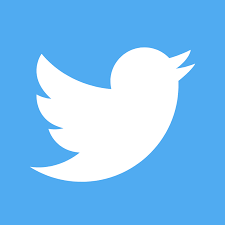</div>

In [1]:
# https://github.com/SohierDane/BigQuery_Helper
from bq_helper import BigQueryHelper

# This establishes an authenticated session and prepares a reference to the dataset that lives in BigQuery.
bq_assistant = BigQueryHelper("bigquery-public-data", "covid19_open_data")
import pandas as pd

# client = bigquery.Client()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import datetime
    
import IPython
import IPython.display
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


# Field name	Type	Mode	Policy tags 	Description
# date	DATE	NULLABLE	
# location_key	STRING	NULLABLE	
# country_code	STRING	NULLABLE	
# country_name	STRING	NULLABLE	
# subregion1_code	STRING	NULLABLE	
# subregion1_name	STRING	NULLABLE	
# subregion2_code	STRING	NULLABLE	
# subregion2_name	STRING	NULLABLE	
# iso_3166_1_alpha_2	STRING	NULLABLE	
# iso_3166_1_alpha_3	STRING	NULLABLE	
# aggregation_level	INTEGER	NULLABLE	
# new_confirmed	INTEGER	NULLABLE	
# new_deceased	INTEGER	NULLABLE	
# new_recovered	INTEGER	NULLABLE	
# new_tested	INTEGER	NULLABLE	
# cumulative_confirmed	INTEGER	NULLABLE	
# cumulative_deceased	INTEGER	NULLABLE	
# cumulative_recovered	INTEGER	NULLABLE	
# cumulative_tested	INTEGER	NULLABLE	
# new_hospitalized_patients	INTEGER	NULLABLE	
# new_intensive_care_patients	INTEGER	NULLABLE	
# new_ventilator_patients	INTEGER	NULLABLE	
# cumulative_hospitalized_patients	INTEGER	NULLABLE	
# cumulative_intensive_care_patients	INTEGER	NULLABLE	
# cumulative_ventilator_patients	INTEGER	NULLABLE	
# current_hospitalized_patients	INTEGER	NULLABLE	
# current_intensive_care_patients	INTEGER	NULLABLE	
# current_ventilator_patients	INTEGER	NULLABLE	
# mobility_transit_stations	INTEGER	NULLABLE	
# mobility_retail_and_recreation	INTEGER	NULLABLE	
# mobility_grocery_and_pharmacy	INTEGER	NULLABLE	
# mobility_parks	INTEGER	NULLABLE	
# mobility_residential	INTEGER	NULLABLE	
# mobility_workplaces	INTEGER	NULLABLE	
# wikidata_id	STRING	NULLABLE	
# datacommons_id	STRING	NULLABLE	
# openstreetmap_id	INTEGER	NULLABLE	
# latitude	FLOAT	NULLABLE	
# longitude	FLOAT	NULLABLE	
# location_geometry	GEOGRAPHY	NULLABLE	
# average_temperature_celsius	FLOAT	NULLABLE	
# minimum_temperature_celsius	FLOAT	NULLABLE	
# maximum_temperature_celsius	FLOAT	NULLABLE	
# rainfall_mm	FLOAT	NULLABLE	
# snowfall_mm	FLOAT	NULLABLE	


covidquery = """


SELECT * FROM `bigquery-public-data.covid19_open_data.covid19_open_data` as covid
 Where covid.country_code = 'US'

"""


In [2]:
#/*#matplotlib inline means that any graph we create, will appear in the same notebook file*/
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics
import seaborn as sns #styling plots
import difflib
import math
from scipy import stats
from scipy.stats import mode
import pandas_profiling
from sklearn.metrics import confusion_matrix

In [4]:
#load libraries for text analytics
#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [5]:
import pycountry_convert as pc
import folium
import plotly.express as px


In [6]:
import warnings

warnings.filterwarnings('ignore')

<h3>BigQuery covid19_open_data Data collection<h3>

In [8]:
def exeQuery(query):
    df = bq_assistant.query_to_pandas_safe(query, max_gb_scanned=100)
    # Look at the first 10
    return df

In [10]:
coviddf = exeQuery(covidquery)
coviddf.head(10)

,date,location_key,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,...,datacommons_id,openstreetmap_id,latitude,longitude,location_geometry,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm
0,2020-07-04,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.788889,19.983333,32.688889,0.000000,NaN
1,2020-07-05,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.927778,20.788889,32.511111,0.846667,NaN
2,2020-07-06,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.216667,21.894444,31.177778,1.397000,NaN
3,2020-07-07,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),24.905556,19.433333,30.850000,2.342444,NaN
4,2020-07-08,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.911111,21.950000,33.505556,3.483429,NaN
5,2020-07-09,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),25.377778,21.161111,32.388889,5.479143,NaN
6,2020-07-10,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),23.516667,17.516667,29.044444,0.965200,NaN
7,2020-07-11,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),23.811111,18.227778,28.716667,1.460500,NaN
8,2020-07-12,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),22.205556,16.400000,28.494444,2.709333,NaN
9,2020-07-13,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),23.511111,16.627778,29.850000,0.000000,NaN


In [14]:
coviddf.columns


Index(['date', 'location_key', 'country_code', 'country_name',
       'subregion1_code', 'subregion1_name', 'subregion2_code',
       'subregion2_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3',
       'aggregation_level', 'new_confirmed', 'new_deceased', 'new_recovered',
       'new_tested', 'cumulative_confirmed', 'cumulative_deceased',
       'cumulative_recovered', 'cumulative_tested',
       'new_hospitalized_patients', 'new_intensive_care_patients',
       'new_ventilator_patients', 'cumulative_hospitalized_patients',
       'cumulative_intensive_care_patients', 'cumulative_ventilator_patients',
       'current_hospitalized_patients', 'current_intensive_care_patients',
       'current_ventilator_patients', 'mobility_transit_stations',
       'mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy',
       'mobility_parks', 'mobility_residential', 'mobility_workplaces',
       'wikidata_id', 'datacommons_id', 'openstreetmap_id', 'latitude',
       'longitude', 'location

In [15]:
coviddf.describe()

,aggregation_level,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,mobility_transit_stations,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_residential,mobility_workplaces,openstreetmap_id,latitude,longitude,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm
count,936225.000000,620973.000000,620549.000000,6.241840e+05,623803.000000,221358.000000,396621.000000,363066.000000,134210.000000,295238.000000,565687.000000,9.356550e+05,936225.000000,936225.000000,926083.000000,926083.000000,926076.000000,926071.000000,56456.000000
mean,1.983257,37.317721,1.052310,3.299216e+03,121.988912,-11.314459,-9.302397,2.309459,37.714634,7.794840,-23.483859,1.600996e+06,37.917060,-91.386355,15.465637,9.882205,22.004560,2.250220,131.212156
std,0.137469,754.632826,24.763951,7.428768e+04,2544.190713,26.480238,21.168156,14.972733,67.613273,6.622747,15.550942,8.617380e+05,6.252684,15.910026,10.002874,10.076719,10.301317,5.608126,135.814102
min,0.000000,-7757.000000,-514.000000,0.000000e+00,0.000000,-243.000000,-268.000000,-192.000000,-292.000000,-46.000000,-296.000000,3.607400e+04,-14.295833,-174.285050,-41.569444,-44.927778,-37.746914,0.000000,10.160000
25%,2.000000,0.000000,0.000000,1.800000e+01,0.000000,-29.000000,-22.000000,-6.000000,-8.000000,3.000000,-33.000000,1.150531e+06,34.320000,-98.090000,8.283333,2.377778,15.150000,0.000000,30.480000
50%,2.000000,1.000000,0.000000,1.000000e+02,2.000000,-9.000000,-7.000000,2.000000,23.000000,7.000000,-25.000000,1.795840e+06,38.220000,-89.920000,17.475309,11.122222,24.555556,0.112889,78.740000
75%,2.000000,7.000000,0.000000,4.980000e+02,12.000000,6.000000,4.000000,10.000000,70.000000,12.000000,-14.000000,1.838138e+06,41.698997,-82.900000,23.808642,18.216667,30.283333,1.834444,180.340000
max,3.000000,74354.000000,6409.000000,7.525920e+06,211311.000000,222.000000,261.000000,225.000000,709.000000,109.000000,66.000000,9.396951e+06,69.300000,145.780000,39.833333,32.550000,47.736111,196.342000,1750.060000


In [16]:
coviddf_copy = coviddf.copy()

In [17]:
coviddf.shape

(936225, 45)

<b>We are selecting USA as country</b>

In [18]:
coviddf_copy = coviddf.loc[coviddf['country_code']=='US']

In [19]:
coviddf_copy.shape

(936225, 45)

In [20]:
coviddf_copy.head(5)

,date,location_key,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,...,datacommons_id,openstreetmap_id,latitude,longitude,location_geometry,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm
0,2020-07-04,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.788889,19.983333,32.688889,0.000000,NaN
1,2020-07-05,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.927778,20.788889,32.511111,0.846667,NaN
2,2020-07-06,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.216667,21.894444,31.177778,1.397000,NaN
3,2020-07-07,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),24.905556,19.433333,30.850000,2.342444,NaN
4,2020-07-08,US_MN_27163,US,United States of America,MN,Minnesota,27163,Washington County,US,USA,...,geoId/27163,1795861.0,45.04,-92.89,POINT(-92.89 45.04),26.911111,21.950000,33.505556,3.483429,NaN


In [21]:
coviddf_copy.columns

Index(['date', 'location_key', 'country_code', 'country_name',
       'subregion1_code', 'subregion1_name', 'subregion2_code',
       'subregion2_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3',
       'aggregation_level', 'new_confirmed', 'new_deceased', 'new_recovered',
       'new_tested', 'cumulative_confirmed', 'cumulative_deceased',
       'cumulative_recovered', 'cumulative_tested',
       'new_hospitalized_patients', 'new_intensive_care_patients',
       'new_ventilator_patients', 'cumulative_hospitalized_patients',
       'cumulative_intensive_care_patients', 'cumulative_ventilator_patients',
       'current_hospitalized_patients', 'current_intensive_care_patients',
       'current_ventilator_patients', 'mobility_transit_stations',
       'mobility_retail_and_recreation', 'mobility_grocery_and_pharmacy',
       'mobility_parks', 'mobility_residential', 'mobility_workplaces',
       'wikidata_id', 'datacommons_id', 'openstreetmap_id', 'latitude',
       'longitude', 'location

In [22]:
def profilingDf(df, html):
    df_report = pandas_profiling.ProfileReport(df)
    df_report.to_file(html)
    return html

In [23]:
html = profilingDf(coviddf_copy, 'covid19_public_datasets.html')
from IPython.display import IFrame
IFrame(src=html, width=1600, height=2000)

<b>preprocessing data</b>

In [24]:
coviddf_copy = coviddf_copy[['date', 'new_confirmed', 'new_deceased', 'new_recovered',
       'new_tested', 'cumulative_confirmed', 'cumulative_deceased',
       'cumulative_recovered', 'cumulative_tested']]

In [25]:
coviddf_copy.head(5)

,date,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
0,2020-07-04,0.0,0.0,None,NaN,1069.0,40.0,None,NaN
1,2020-07-05,13.0,0.0,None,NaN,1082.0,40.0,None,NaN
2,2020-07-06,32.0,0.0,None,NaN,1114.0,40.0,None,NaN
3,2020-07-07,23.0,0.0,None,NaN,1137.0,40.0,None,NaN
4,2020-07-08,26.0,0.0,None,NaN,1163.0,40.0,None,NaN


In [26]:
coviddf_copy.isnull().sum()

date                         0
new_confirmed           315252
new_deceased            315676
new_recovered           927737
new_tested              923525
cumulative_confirmed    312041
cumulative_deceased     312422
cumulative_recovered    927733
cumulative_tested       923470
dtype: int64

In [27]:
coviddf_copy[['new_confirmed', 'new_deceased', 'new_recovered','new_tested']] = coviddf_copy[['new_confirmed', 'new_deceased', 'new_recovered','new_tested']].replace(np.nan, 0)

In [16]:
coviddf_copy['subregion1_code'] = coviddf_copy['subregion1_code'].replace(np.nan, 'unknown')

In [17]:
coviddf_copy['subregion1_code'].isnull().sum()

0

In [18]:
coviddf_copy['subregion1_name'] = coviddf_copy['subregion1_name'].replace(np.nan, 'unknown')
coviddf_copy['subregion2_code'] = coviddf_copy['subregion2_code'].replace(np.nan, 'unknown')
coviddf_copy['subregion2_name'] = coviddf_copy['subregion2_name'].replace(np.nan, 'unknown')

In [28]:
coviddf_copy['date'] = pd.to_datetime(coviddf_copy['date'])

In [29]:
coviddf_copy['date']

0        2020-07-04
1        2020-07-05
2        2020-07-06
3        2020-07-07
4        2020-07-08
            ...    
936220   2020-06-17
936221   2020-06-18
936222   2020-06-19
936223   2020-06-20
936224   2020-06-21
Name: date, Length: 936225, dtype: datetime64[ns]

In [30]:
#origial date is not sorted, need to sort it
coviddf_copy = coviddf_copy.sort_values(by='date')

In [31]:
coviddf_copy.sort_values(by='cumulative_confirmed')

,date,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
578697,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
669654,2020-03-08,0.0,0.0,0.0,5.0,0.0,NaN,NaN,5
587599,2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
699579,2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1
811877,2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,48
...,...,...,...,...,...,...,...,...,...
533618,2020-10-11,0.0,0.0,0.0,0.0,NaN,NaN,None,None
649321,2020-10-11,0.0,0.0,0.0,0.0,NaN,NaN,None,None
377695,2020-10-11,0.0,0.0,0.0,0.0,NaN,NaN,None,None
763412,2020-10-11,0.0,0.0,0.0,0.0,NaN,NaN,None,None


In [174]:
coviddf_copy.head(5)

,date,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
126005,2020-01-01,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
381467,2020-01-01,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
270894,2020-01-01,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
906276,2020-01-01,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
464620,2020-01-01,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [32]:
corr_coviddf_copy = coviddf_copy.corr()
corr_coviddf_copy

,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased
new_confirmed,1.000000,0.728072,0.099706,0.893947,0.861024,0.876637
new_deceased,0.728072,1.000000,0.081050,0.601621,0.555215,0.615704
new_recovered,0.099706,0.081050,1.000000,0.058234,0.079517,0.061001
new_tested,0.893947,0.601621,0.058234,1.000000,0.890949,0.918156
cumulative_confirmed,0.861024,0.555215,0.079517,0.890949,1.000000,0.963283
cumulative_deceased,0.876637,0.615704,0.061001,0.918156,0.963283,1.000000


<AxesSubplot:>

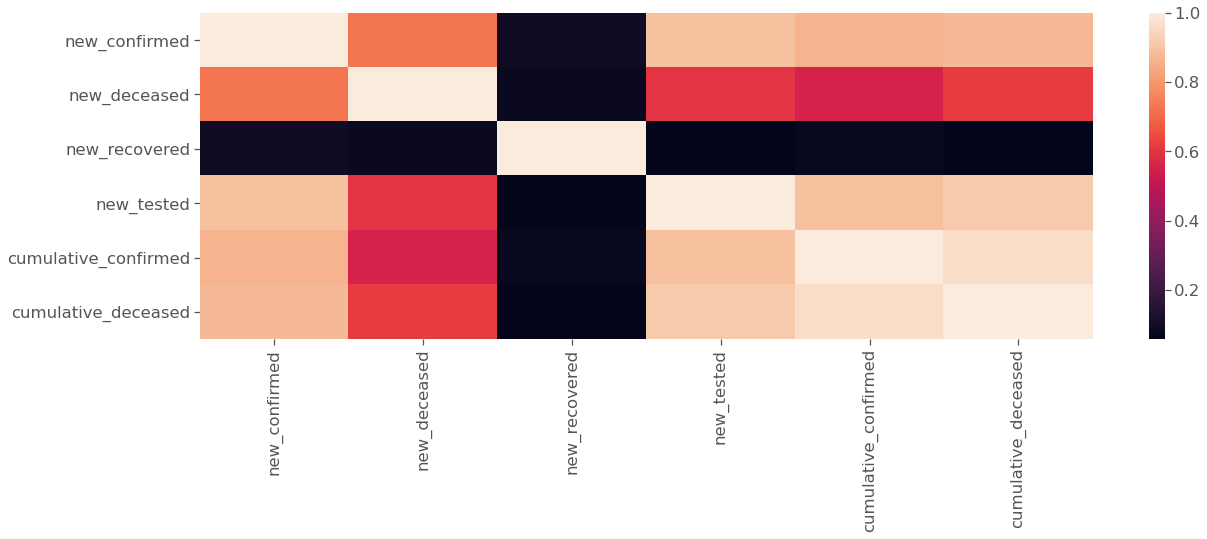

In [33]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(20,6))
sns.heatmap(corr_coviddf_copy, 
        xticklabels=corr_coviddf_copy.columns,
        yticklabels=corr_coviddf_copy.columns)

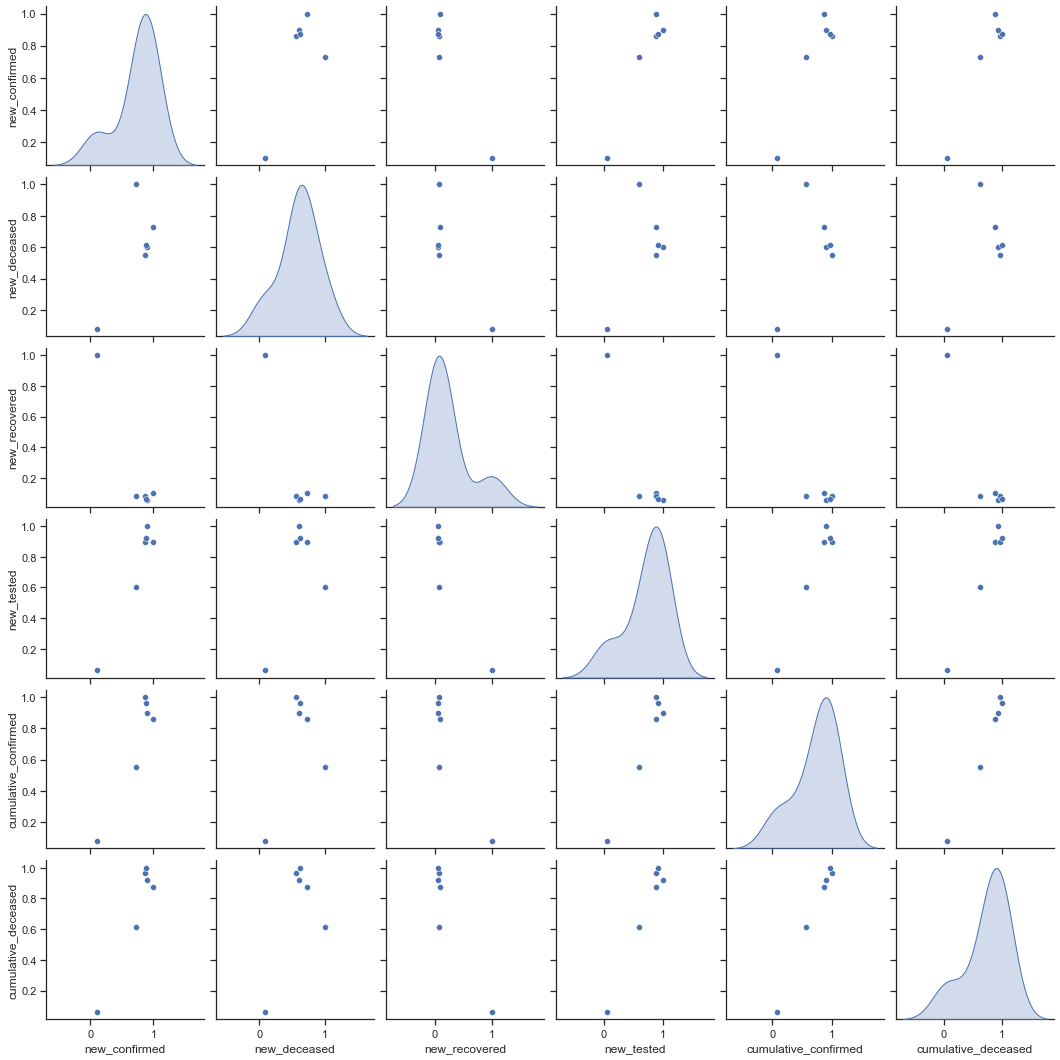

In [177]:
sns.pairplot(corr_coviddf_copy, diag_kind="kde")

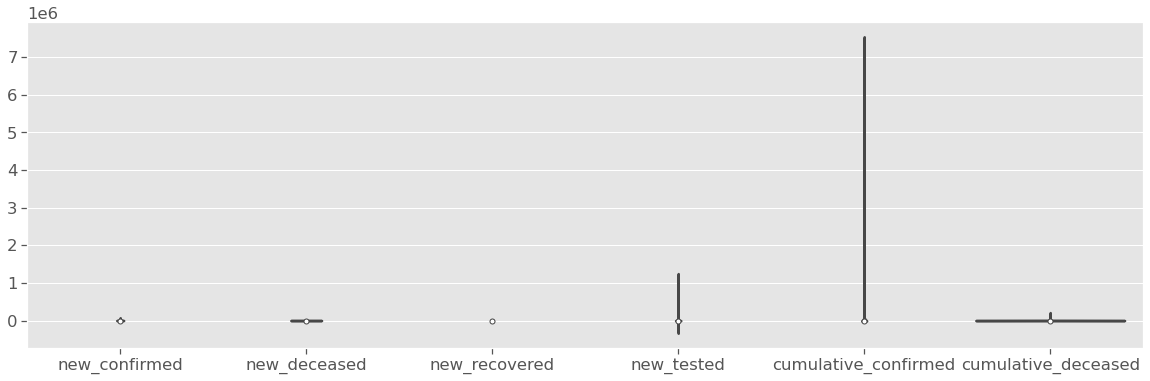

In [34]:
fig, ax = pyplot.subplots(figsize=(20,6))
violin_t = sns.violinplot(ax=ax,data=coviddf_copy)

In [35]:
# because new_confirmed and new_recovery have the lowest correleation, we use them as clustering
coviddf_copy_features = coviddf_copy[['date','new_confirmed', 'new_recovered']]

In [182]:
coviddf_copy_features.head(5)

,date,new_confirmed,new_tested
126005,2020-01-01,0.0,0.0
381467,2020-01-01,0.0,0.0
270894,2020-01-01,0.0,0.0
906276,2020-01-01,0.0,0.0
464620,2020-01-01,0.0,0.0


In [36]:
# df.groupby(pd.to_datetime(df.time).dt.date).agg({'raccoons_bought': 'sum', 'x':'first', 'y':'first'}).reset_index() 
coviddf_copy_features = coviddf_copy_features.groupby(coviddf_copy_features['date']).agg({'new_confirmed': 'sum', 'new_recovered':'sum'}).reset_index() 

In [37]:
coviddf_copy_features.head(5)

,date,new_confirmed,new_recovered
0,2020-01-01,0.0,0.0
1,2020-01-02,0.0,0.0
2,2020-01-03,0.0,0.0
3,2020-01-04,0.0,0.0
4,2020-01-05,0.0,0.0


In [38]:
date_time = pd.to_datetime(coviddf_copy_features.pop('date'))

In [39]:
#Here is the evolution of a few features over time.
def evolutionOvertime(df, feature):
    plot_cols = [feature]
    plot_features = df[plot_cols]
    plot_features.index = date_time
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:480]
    plot_features.index = date_time[:480]
    _ = plot_features.plot(subplots=True)

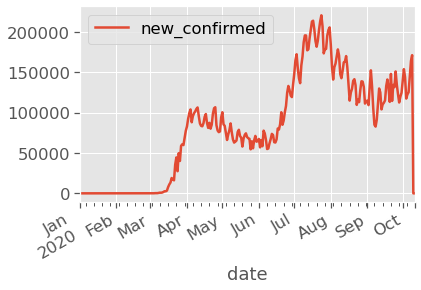

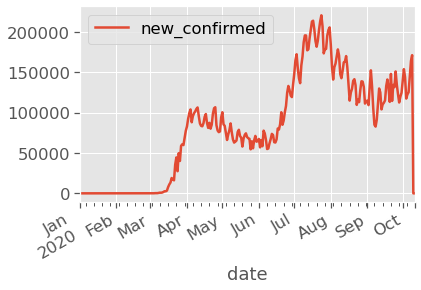

In [40]:
evolutionOvertime(coviddf_copy_features, 'new_confirmed')

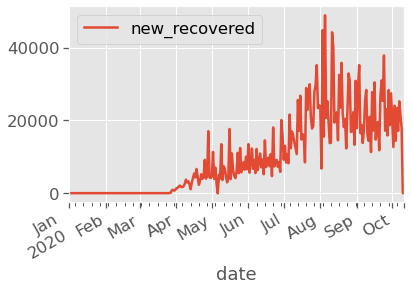

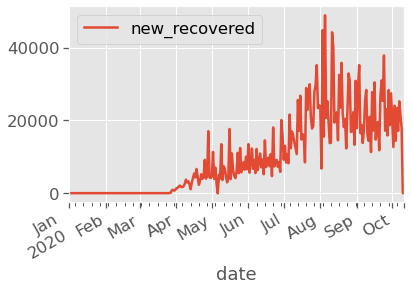

In [41]:
evolutionOvertime(coviddf_copy_features, 'new_recovered')

<h3>clustering</h3>
<b>Because we start with data from 2019-11-01 to 2020-04-01, we cluster this part of datasets and decide labels</b>

In [42]:
coviddf_copy_features_tmp = coviddf_copy_features.copy()
coviddf_copy_features_tmp

,new_confirmed,new_recovered
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
280,144414.0,25240.0
281,163873.0,21301.0
282,171143.0,17848.0
283,0.0,0.0


In [43]:
#usa public covid data start from 2020-01-01
# coviddf_copy_features_tmp = coviddf_copy_features.copy()
coviddf_copy_features_tmp['date'] = date_time.values
coviddf_copy_features_tmp = coviddf_copy_features_tmp.loc[(coviddf_copy_features_tmp['date']>='2020-01-01') & (coviddf_copy_features_tmp['date']<'2020-04-01')]
# coviddf_copy_features_tmp = coviddf_copy_features_tmp.drop(['date'], axis=1)

In [44]:
coviddf_copy_features_tmp.head(10)

,new_confirmed,new_recovered,date
0,0.0,0.0,2020-01-01
1,0.0,0.0,2020-01-02
2,0.0,0.0,2020-01-03
3,0.0,0.0,2020-01-04
4,0.0,0.0,2020-01-05
5,0.0,0.0,2020-01-06
6,0.0,0.0,2020-01-07
7,0.0,0.0,2020-01-08
8,0.0,0.0,2020-01-09
9,0.0,0.0,2020-01-10


[[ 2.40772857e+04  6.28571429e+00]
 [ 5.99227143e+04  4.77142857e+02]
 [ 4.32129870e+02 -7.10542736e-15]]


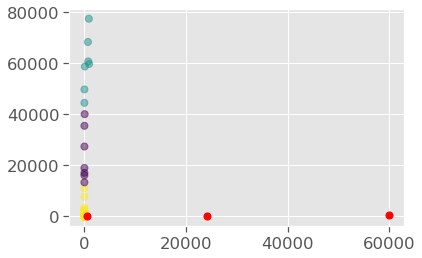

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, verbose=0).fit(coviddf_copy_features_tmp[['new_confirmed','new_recovered']])
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(coviddf_copy_features_tmp['new_recovered'], coviddf_copy_features_tmp['new_confirmed'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [46]:
np.unique(kmeans.labels_, return_counts=1)

(array([0, 1, 2]), array([ 7,  7, 77], dtype=int64))

In [47]:
coviddf_copy_features_tmp['cluster'] = kmeans.labels_

In [48]:
coviddf_copy_features_tmp

,new_confirmed,new_recovered,date,cluster
0,0.0,0.0,2020-01-01,2
1,0.0,0.0,2020-01-02,2
2,0.0,0.0,2020-01-03,2
3,0.0,0.0,2020-01-04,2
4,0.0,0.0,2020-01-05,2
...,...,...,...,...
86,58767.0,89.0,2020-03-27,1
87,60772.0,756.0,2020-03-28,1
88,59762.0,932.0,2020-03-29,1
89,68384.0,688.0,2020-03-30,1


<b>calculate the boundaries of clusters [0,1,2]</b>

In [49]:
# cluster 2 -> the spread inclince to lessen
cluster_2_max = np.max(coviddf_copy_features_tmp.loc[coviddf_copy_features_tmp['cluster']==2]['new_confirmed'])
print(cluster_2_max)
cluster_2_min = np.min(coviddf_copy_features_tmp.loc[coviddf_copy_features_tmp['cluster']==2]['new_confirmed'])
print(cluster_2_min)

# cluster 1 ->  the spread is more intense
cluster_1_max = np.max(coviddf_copy_features_tmp.loc[coviddf_copy_features_tmp['cluster']==1]['new_confirmed'])
print(cluster_1_max)
cluster_1_min = np.min(coviddf_copy_features_tmp.loc[coviddf_copy_features_tmp['cluster']==1]['new_confirmed'])
print(cluster_1_min)

# cluster 0 ->  the spread is smooth 
cluster_0_max = np.max(coviddf_copy_features_tmp.loc[coviddf_copy_features_tmp['cluster']==0]['new_confirmed'])
print(cluster_0_max)
cluster_0_min = np.min(coviddf_copy_features_tmp.loc[coviddf_copy_features_tmp['cluster']==0]['new_confirmed'])
print(cluster_0_min)

10996.0
0.0
77485.0
44512.0
40079.0
13350.0


<b>Above the labels boundaries are:</b>
<ul>
    <li>
        from 0 to 13350 is labelled as 2 -> the spread is lessen
    </li>
    <li>
        from 13351 to 40079 is labelled as 0 ->  the spread inclince to smooth
    </li>
    <li>
        from 40079 above is labelled as 1 ->  the spread is more intense
    </li>
    </ul>
   <b>apply these labels for total.</b>

In [383]:
coviddf_copy_features['cluster'] = 0
coviddf_copy_features['cluster'].loc[coviddf_copy_features['new_confirmed']<=10996] = 2
coviddf_copy_features['cluster'].loc[(coviddf_copy_features['new_confirmed']>10996) & (coviddf_copy_features['new_confirmed']<=44512)] = 0
coviddf_copy_features['cluster'].loc[coviddf_copy_features['new_confirmed']>44512] = 1

In [384]:
np.unique(coviddf_copy_features['cluster'].values, return_counts=1)

(array([0, 1, 2], dtype=int64), array([  8, 198,  79], dtype=int64))

In [52]:
coviddf_copy_features['date'] = date_time.values

In [88]:
coviddf_copy_features.head(5)

,new_confirmed,new_recovered,cluster,date
0,0.0,0.0,2,2020-01-01
1,0.0,0.0,2,2020-01-02
2,0.0,0.0,2,2020-01-03
3,0.0,0.0,2,2020-01-04
4,0.0,0.0,2,2020-01-05


<h3>twitter accounts fenching<h3>
CDC (@CDCgov) <br>
HHS.gov (@HHSGov) <br>
CDC Emergency (@CDCemergency) <br>
APHA (@PublicHealth) <br>
NIH (@NIH) <br>
WHO (@WHO) <br>
US-FDA (@us-fda) <br>
Health and Wellness (@nshealth)

In [50]:
#references:
#http://adilmoujahid.com/posts/2014/07/twitter-analytics/
#https://medium.com/analytics-vidhya/tweet-analytics-using-nlp-f83b9f7f7349
#https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c

<h4>Step 1: Collect tweets</h4>
# Build your model based on the data from November 1, 2019, to April 1,
# 2020. Apply the data from April 1, 2020, to September 1, 2020, as your model's
# development dataset. Then use the data from September 1, 2020, to October
# 1, 2020

In [352]:
import tweepy
import csv
consumerKey = "kEPYuwVwdo1Xpxr3O3ZCwkRp8"
consumerSecret = "BTK3ETS7Y6U6SG6gvlCf1Az6srYoqeXA1TGo8en1WqoxwGjTIH"
accessToken = "98424472-HMSkrmvtR26K1Jy5nkMcCqggsItg6s9bbrejzpVG5"
accessTokenSecret = "YnHPw7uYbERGEz5csA6MkfRYC8wHgZ8UWbkPe3quvqqxC"

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)

api = tweepy.API(auth, wait_on_rate_limit=True)

startDate = datetime.datetime(2019, 11, 1, 0, 0, 0)
endDate =   datetime.datetime(2020, 10, 1, 0, 0, 0)

def fetchOneTwitterAccount(username):
    tweets = []
    tmpTweets = api.user_timeline(username)
    for tweet in tmpTweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:
            tweets.append(tweet)

    previousTweetTime = ''
    while ((tmpTweets[-1].created_at > startDate) and (tmpTweets[-1].created_at != previousTweetTime)):
        previousTweetTime = tmpTweets[-1].created_at
        tmpTweets = api.user_timeline(username, max_id = tmpTweets[-1].id)
        for tweet in tmpTweets:
            if tweet.created_at < endDate and tweet.created_at > startDate:
                tweets.append(tweet)

    return tweets


In [12]:
#define reusable function to create df from tweepy resultsets
def getDfFromTweepy(tweets):
    my_list_of_dicts = []
    for each_json_tweet in tweets:
        filteredObj = {}
        filteredObj['date'] = each_json_tweet.created_at
        filteredObj['id_str'] = each_json_tweet.id_str
        filteredObj['text'] = each_json_tweet.text
        filteredObj['hashtags'] = map(lambda x: x.text,each_json_tweet.entities['hashtags'])
        filteredObj['user_mentions'] = map(lambda x: x.name,each_json_tweet.entities['user_mentions'])
        filteredObj['tweeter_account'] = each_json_tweet.user.screen_name
        my_list_of_dicts.append(filteredObj)
    myDf = pd.DataFrame.from_records(my_list_of_dicts)
    myDf['date'] = pd.to_datetime(myDf['date'])
    myDf = myDf.sort_values(by='date')
    return myDf
        

In [353]:
# test with cdc firstly to see the tweet structure
cdc_tweets = fetchOneTwitterAccount('@CDCgov')

In [211]:
cdc_tweets[1000]._json

{'created_at': 'Tue Jul 21 13:08:01 +0000 2020',
 'id': 1285562172056182786,
 'id_str': '1285562172056182786',
 'text': 'RT @HHSGov: Smoking during pregnancy can increase the chance of delivering a baby with an oral cleft. Make the right move for you and your…',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'HHSGov',
    'name': 'HHS.gov',
    'id': 44783853,
    'id_str': '44783853',
    'indices': [3, 10]}],
  'urls': []},
 'source': '<a href="https://sproutsocial.com" rel="nofollow">Sprout Social</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 146569971,
  'id_str': '146569971',
  'name': 'CDC',
  'screen_name': 'CDCgov',
  'location': 'Atlanta, GA',
  'description': "CDC's official Twitter source for daily credible health & safety updates from Centers for Disease Control & Prevention. Pr

In [354]:
cdc_tweets_df = getDfFromTweepy(cdc_tweets)

In [ ]:
cdc_tweets_df.head(10)

In [355]:
# CDC (@CDCgov)
# HHS.gov (@HHSGov)
# CDC Emergency (@CDCemergency)
# APHA (@PublicHealth)
# NIH (@NIH)
# WHO (@WHO)
# US_FDA (@US_FDA)
# Health and Wellness (@nshealth)
hhs_tweets = fetchOneTwitterAccount('@HHSGov')
hhs_tweets_df = getDfFromTweepy(hhs_tweets)
cdc_emergency_tweets = fetchOneTwitterAccount('@CDCemergency')
cdc_emergency_tweets_df = getDfFromTweepy(cdc_emergency_tweets)
apha_emergency_tweets = fetchOneTwitterAccount('@PublicHealth')
apha_emergency_tweets_df = getDfFromTweepy(apha_emergency_tweets)
nih_tweets = fetchOneTwitterAccount('@NIH')
nih_tweets_df = getDfFromTweepy(nih_tweets)
who_tweets = fetchOneTwitterAccount('@WHO')
who_tweets_df = getDfFromTweepy(who_tweets)
fda_tweets = fetchOneTwitterAccount('@US_FDA')
fda_tweets_df = getDfFromTweepy(fda_tweets)
nshealth_tweets = fetchOneTwitterAccount('@nshealth')
nshealth_tweets_df = getDfFromTweepy(nshealth_tweets)

In [60]:
fda_tweets[1000]._json

{'created_at': 'Wed May 13 15:39:26 +0000 2020',
 'id': 1260595514892058625,
 'id_str': '1260595514892058625',
 'text': 'In our latest #FDAVoices, read how FDA is reaching a significant milestone in the regulation of human drug compound… https://t.co/Q7YQ2xBie2',
 'truncated': True,
 'entities': {'hashtags': [{'text': 'FDAVoices', 'indices': [14, 24]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/Q7YQ2xBie2',
    'expanded_url': 'https://twitter.com/i/web/status/1260595514892058625',
    'display_url': 'twitter.com/i/web/status/1…',
    'indices': [117, 140]}]},
 'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 208120290,
  'id_str': '208120290',
  'name': 'U.S. FDA',
  'screen_name': 'US_FDA',
  'location': 'Silver Spring, MD',
  

<b>Concatenating the five tweets acounts data</b>

In [356]:
frames = [cdc_tweets_df, hhs_tweets_df, cdc_emergency_tweets_df, apha_emergency_tweets_df, nih_tweets_df, who_tweets_df, fda_tweets_df, nshealth_tweets_df]
df_total_tweets = pd.concat(frames)

In [357]:
df_total_tweets['date'] = pd.to_datetime(df_total_tweets['date'])
df_total_tweets = df_total_tweets.sort_values(by='date')

In [358]:
df_total_tweets.shape

(19191, 6)

In [359]:
df_total_tweets.head(10)

,date,id_str,text,hashtags,user_mentions,tweeter_account
2116,2019-11-01 12:01:00,1190237299109515269,Are you one of the 15 million women in the U.S...,<map object at 0x00000206869D2D60>,<map object at 0x00000206869D2DF0>,US_FDA
2301,2019-11-01 12:02:35,1190237700374310912,RT @SecAzar: The payment reforms announced tod...,<map object at 0x0000020686BE9F70>,<map object at 0x0000020686C0B040>,HHSGov
2115,2019-11-01 12:15:50,1190241034434994178,RT @FDArecalls: Nestlé USA Announces Voluntary...,<map object at 0x00000206869D2C40>,<map object at 0x00000206869D2CD0>,US_FDA
2300,2019-11-01 14:03:00,1190268001129500673,RT @Surgeon_General: Thanks @tvkatesnow &amp; ...,<map object at 0x0000020686BE9E50>,<map object at 0x0000020686BE9EE0>,HHSGov
1635,2019-11-01 14:45:17,1190278641432829952,Remember to #FallBack an hour this Sunday &amp...,<map object at 0x00000206A2AD3310>,<map object at 0x00000206A2AD30D0>,CDCemergency
2299,2019-11-01 14:48:00,1190279325788069889,RT @NIHDirector: Cause for celebration! 30 yea...,<map object at 0x0000020686BE9D30>,<map object at 0x0000020686BE9DC0>,HHSGov
2951,2019-11-01 15:01:02,1190282608887914496,The rotavirus vaccine has been added to Nova S...,<map object at 0x0000020663F5A220>,<map object at 0x0000020663F5A2B0>,nshealth
2950,2019-11-01 15:01:03,1190282611706548224,The rotavirus vaccine is given orally to babie...,<map object at 0x0000020663F5A100>,<map object at 0x0000020663F5A190>,nshealth
2949,2019-11-01 15:01:04,1190282613526847488,"To get the rotavirus vaccine, along with other...",<map object at 0x0000020663F7DFA0>,<map object at 0x0000020663F5A070>,nshealth
2298,2019-11-01 15:11:01,1190285118625202179,#OpenEnrollment starts today. Visit https://t....,<map object at 0x0000020686BE9C10>,<map object at 0x0000020686BE9CA0>,HHSGov


In [360]:
df_total_tweets.tail(10)

,date,id_str,text,hashtags,user_mentions,tweeter_account
3,2020-09-30 21:35:51,1311419512454025220,We updated the SARS CoV-2 reference panel comp...,<map object at 0x0000020624E5DFA0>,<map object at 0x00000206864FB160>,US_FDA
4,2020-09-30 21:35:51,1311419511195795463,Here’s a look at some of the FDA’s latest acti...,<map object at 0x00000206864FB4C0>,<map object at 0x00000206864FB5E0>,US_FDA
0,2020-09-30 21:35:52,1311419515603947524,"As of today, 263 tests are authorized by FDA u...",<map object at 0x00000206684F3BE0>,<map object at 0x00000206949615E0>,US_FDA
4,2020-09-30 21:57:32,1311424971613319169,"As of September 27, #COVID19 cases were trendi...",<map object at 0x00000206A4FAA880>,<map object at 0x00000206A4FAAA60>,CDCgov
3,2020-09-30 21:57:33,1311424974989807618,Increases in #COVID19 vary by urbanization. Ov...,<map object at 0x00000206A4FAABE0>,<map object at 0x00000206A4FAA5E0>,CDCgov
2,2020-09-30 22:07:02,1311427358423998467,RT @vibrantforall: Check out parts 1 and 2 of ...,<map object at 0x00000206A4FAA7C0>,<map object at 0x00000206A4FAAF10>,CDCgov
0,2020-09-30 22:20:03,1311430637774135296,Photographers have had to find new ways to #St...,<map object at 0x00000206A0FAD940>,<map object at 0x00000206A2D000A0>,CDCemergency
1,2020-09-30 22:20:03,1311430637774135296,Photographers have had to find new ways to #St...,<map object at 0x000002060268A940>,<map object at 0x000002060268A190>,CDCemergency
1,2020-09-30 22:33:01,1311433898178621441,RT @HHSGov: A mask is one of the best ways to ...,<map object at 0x00000206A4FAA490>,<map object at 0x00000206A4FAAC70>,CDCgov
0,2020-09-30 23:04:00,1311441697528852482,RT @CDCFlu: Clinicians: Put your practice on t...,<map object at 0x00000206A4FAA3A0>,<map object at 0x00000206A4FAA430>,CDCgov


### Shifting 14 Days
<h4>Because we are predicting the new_claimed number after 14 days, we are shifting the "date" column up to 14 records of df_total_tweets</h4>

In [361]:
from datetime import timedelta
df_total_tweets["expected_date"] = df_total_tweets["date"]
df_total_tweets["expected_date"] = df_total_tweets["expected_date"] + timedelta(days=14)
df_total_tweets['expected_date'] = df_total_tweets['expected_date'].map(lambda x: x.strftime('%Y-%m-%d'))

In [362]:
df_total_tweets.head(5)

,date,id_str,text,hashtags,user_mentions,tweeter_account,expected_date
2116,2019-11-01 12:01:00,1190237299109515269,Are you one of the 15 million women in the U.S...,<map object at 0x00000206869D2D60>,<map object at 0x00000206869D2DF0>,US_FDA,2019-11-15
2301,2019-11-01 12:02:35,1190237700374310912,RT @SecAzar: The payment reforms announced tod...,<map object at 0x0000020686BE9F70>,<map object at 0x0000020686C0B040>,HHSGov,2019-11-15
2115,2019-11-01 12:15:50,1190241034434994178,RT @FDArecalls: Nestlé USA Announces Voluntary...,<map object at 0x00000206869D2C40>,<map object at 0x00000206869D2CD0>,US_FDA,2019-11-15
2300,2019-11-01 14:03:00,1190268001129500673,RT @Surgeon_General: Thanks @tvkatesnow &amp; ...,<map object at 0x0000020686BE9E50>,<map object at 0x0000020686BE9EE0>,HHSGov,2019-11-15
1635,2019-11-01 14:45:17,1190278641432829952,Remember to #FallBack an hour this Sunday &amp...,<map object at 0x00000206A2AD3310>,<map object at 0x00000206A2AD30D0>,CDCemergency,2019-11-15


In [363]:
df_total_tweets.shape

(19191, 7)

In [364]:
df_total_tweets.columns

Index(['date', 'id_str', 'text', 'hashtags', 'user_mentions',
       'tweeter_account', 'expected_date'],
      dtype='object')

<b> integration of big query data and tweets </b>

In [365]:
#derive the year from tweets dataset
df_total_tweets['datetime'] = df_total_tweets['date']
df_total_tweets['date']=df_total_tweets['datetime'].map(lambda x: x.strftime('%Y-%m-%d'))

In [366]:
#features selection
df_total_tweets = df_total_tweets[['date', 'text', 'datetime', 'expected_date']]

In [386]:
df_total_tweets.head(10)

,date,text,datetime,expected_date
2116,2019-11-01,Are you one of the 15 million women in the U.S...,2019-11-01 12:01:00,2019-11-15
2301,2019-11-01,RT @SecAzar: The payment reforms announced tod...,2019-11-01 12:02:35,2019-11-15
2115,2019-11-01,RT @FDArecalls: Nestlé USA Announces Voluntary...,2019-11-01 12:15:50,2019-11-15
2300,2019-11-01,RT @Surgeon_General: Thanks @tvkatesnow &amp; ...,2019-11-01 14:03:00,2019-11-15
1635,2019-11-01,Remember to #FallBack an hour this Sunday &amp...,2019-11-01 14:45:17,2019-11-15
2299,2019-11-01,RT @NIHDirector: Cause for celebration! 30 yea...,2019-11-01 14:48:00,2019-11-15
2951,2019-11-01,The rotavirus vaccine has been added to Nova S...,2019-11-01 15:01:02,2019-11-15
2950,2019-11-01,The rotavirus vaccine is given orally to babie...,2019-11-01 15:01:03,2019-11-15
2949,2019-11-01,"To get the rotavirus vaccine, along with other...",2019-11-01 15:01:04,2019-11-15
2298,2019-11-01,#OpenEnrollment starts today. Visit https://t....,2019-11-01 15:11:01,2019-11-15


In [387]:
coviddf_copy_features = coviddf_copy_features.drop(['expected_date'], axis=1)

In [388]:
df_total_tweets['date'] = df_total_tweets['date'].astype(str)
df_total_tweets['expected_date'] = df_total_tweets['expected_date'].astype(str)
coviddf_copy_features['date'] = coviddf_copy_features['date'].astype(str)
merged_datasets_orig = pd.merge(df_total_tweets, coviddf_copy_features, on='date', how='inner')

In [370]:
merged_datasets_orig.head(2)

,date,text,datetime,expected_date,new_confirmed,new_recovered,cluster
0,2020-01-01,"If you’ve been drinking, it’s better to crash ...",2020-01-01 04:30:17,2020-01-15,0.0,0.0,2
1,2020-01-01,Cheers to #2020. We hope this is the happiest ...,2020-01-01 13:00:08,2020-01-15,0.0,0.0,2


In [389]:
#because USA covid 19 datasets begin from 2020-01-01, so fill in the new_confirmed and nrew_recovery NaN value with 0
merged_datasets_orig['new_confirmed'] = merged_datasets_orig['new_confirmed'].replace(np.nan, 0)
merged_datasets_orig['new_recovered'] = merged_datasets_orig['new_recovered'].replace(np.nan, 0)

In [372]:
merged_datasets_orig.head(2)

,date,text,datetime,expected_date,new_confirmed,new_recovered,cluster
0,2020-01-01,"If you’ve been drinking, it’s better to crash ...",2020-01-01 04:30:17,2020-01-15,0.0,0.0,2
1,2020-01-01,Cheers to #2020. We hope this is the happiest ...,2020-01-01 13:00:08,2020-01-15,0.0,0.0,2


In [390]:
# cluster 2 means no spread. we need to replace cluster column NaN value with 2
merged_datasets_orig['cluster'] = merged_datasets_orig['cluster'].replace(np.nan, 2)

In [391]:
#change feature cluster name to spread to make more sense
merged_datasets_orig['spread'] = merged_datasets_orig['cluster'] 
merged_datasets_orig = merged_datasets_orig.drop(['cluster'], axis=1)

In [392]:
merged_datasets_orig.head(2)

,date,text,datetime,expected_date,new_confirmed,new_recovered,spread
0,2020-01-01,"If you’ve been drinking, it’s better to crash ...",2020-01-01 04:30:17,2020-01-15,0.0,0.0,2
1,2020-01-01,Cheers to #2020. We hope this is the happiest ...,2020-01-01 13:00:08,2020-01-15,0.0,0.0,2


### Generating predicted_spread column by Shifting 14 Days
<h4>Because we are predicting the new_claimed number after 14 days, we are generating the predicted spread label by shifting the "date" column up to 14 records of merged_datasets</h4>

In [376]:
coviddf_copy_features

,new_confirmed,new_recovered,cluster,date
0,0.0,0.0,2,2020-01-01
1,0.0,0.0,2,2020-01-02
2,0.0,0.0,2,2020-01-03
3,0.0,0.0,2,2020-01-04
4,0.0,0.0,2,2020-01-05
...,...,...,...,...
280,144414.0,25240.0,1,2020-10-07
281,163873.0,21301.0,1,2020-10-08
282,171143.0,17848.0,1,2020-10-09
283,0.0,0.0,2,2020-10-10


In [393]:
coviddf_copy_features['expected_date'] = coviddf_copy_features['date']
merged_datasets = pd.merge(merged_datasets_orig, coviddf_copy_features, on='expected_date', how='inner')

In [394]:
merged_datasets.head(5000)

,date_x,text,datetime,expected_date,new_confirmed_x,new_recovered_x,spread,new_confirmed_y,new_recovered_y,cluster,date_y
0,2020-01-01,"If you’ve been drinking, it’s better to crash ...",2020-01-01 04:30:17,2020-01-15,0.0,0.0,2,0.0,0.0,2,2020-01-15
1,2020-01-01,Cheers to #2020. We hope this is the happiest ...,2020-01-01 13:00:08,2020-01-15,0.0,0.0,2,0.0,0.0,2,2020-01-15
2,2020-01-01,Fitting physical activity into your day doesn'...,2020-01-01 15:17:01,2020-01-15,0.0,0.0,2,0.0,0.0,2,2020-01-15
3,2020-01-01,CDC wishes you and your family a healthy and #...,2020-01-01 15:33:01,2020-01-15,0.0,0.0,2,0.0,0.0,2,2020-01-15
4,2020-01-01,"This year, APHA resolves to champion the healt...",2020-01-01 16:18:29,2020-01-15,0.0,0.0,2,0.0,0.0,2,2020-01-15
...,...,...,...,...,...,...,...,...,...,...,...
4995,2020-04-09,Most people who get #COVID19 will get better a...,2020-04-09 19:40:02,2020-04-23,104600.0,3718.0,1,98699.0,3943.0,1,2020-04-23
4996,2020-04-09,RT @CDCgov: Make #handwashing a family activit...,2020-04-09 19:44:00,2020-04-23,104600.0,3718.0,1,98699.0,3943.0,1,2020-04-23
4997,2020-04-09,RT @CDCgov: Most people who get #COVID19 will ...,2020-04-09 19:47:17,2020-04-23,104600.0,3718.0,1,98699.0,3943.0,1,2020-04-23
4998,2020-04-09,RT @CDCgov: Most people who get #COVID19 will ...,2020-04-09 19:47:17,2020-04-23,104600.0,3718.0,1,98699.0,3943.0,1,2020-04-23


In [395]:
merged_datasets['new_confirmed'] = merged_datasets['new_confirmed_x']
merged_datasets['new_recovered'] = merged_datasets['new_recovered_x']
merged_datasets['date'] = merged_datasets['date_x']
merged_datasets['expected_new_confirmed'] = merged_datasets['new_confirmed_y']
merged_datasets['expected_new_recovered'] = merged_datasets['new_recovered_y']

In [396]:
merged_datasets = merged_datasets.drop(['new_confirmed_x','new_recovered_x','new_confirmed_y','new_recovered_y', 'date_x', 'date_y'],axis=1)

In [397]:
merged_datasets['expected_spread'] = merged_datasets['cluster']
merged_datasets['expected_spread'] = merged_datasets['expected_spread'].replace(np.nan, 2)
merged_datasets = merged_datasets.drop(['cluster'],axis=1)

In [398]:
merged_datasets.head(3000)

,text,datetime,expected_date,spread,new_confirmed,new_recovered,date,expected_new_confirmed,expected_new_recovered,expected_spread
0,"If you’ve been drinking, it’s better to crash ...",2020-01-01 04:30:17,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2
1,Cheers to #2020. We hope this is the happiest ...,2020-01-01 13:00:08,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2
2,Fitting physical activity into your day doesn'...,2020-01-01 15:17:01,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2
3,CDC wishes you and your family a healthy and #...,2020-01-01 15:33:01,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2
4,"This year, APHA resolves to champion the healt...",2020-01-01 16:18:29,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...
2995,"@HalifaxGuy22 Hi there, it's tweeted in Englis...",2020-03-15 20:23:33,2020-03-29,2,3384.0,0.0,2020-03-15,59762.0,932.0,1
2996,"@senatorsfanNS I'm sorry, I don't understand y...",2020-03-15 20:25:15,2020-03-29,2,3384.0,0.0,2020-03-15,59762.0,932.0,1
2997,"@JessicaCM9 Hello Jessica, all licensed and un...",2020-03-15 20:39:02,2020-03-29,2,3384.0,0.0,2020-03-15,59762.0,932.0,1
2998,@senatorsfanNS The incubation period or time t...,2020-03-15 20:40:32,2020-03-29,2,3384.0,0.0,2020-03-15,59762.0,932.0,1


In [399]:
#because USA covid 19 datasets begin from 2020-01-01, so fill in the new_confirmed and nrew_recovery NaN value with 0
merged_datasets['expected_new_confirmed'] = merged_datasets['expected_new_confirmed'].replace(np.nan, 0)
merged_datasets['expected_new_recovered'] = merged_datasets['expected_new_recovered'].replace(np.nan, 0)

In [400]:
#give the label name to spread
merged_datasets['label_name'] = np.nan
merged_datasets['label_name'].loc[merged_datasets['spread']==0] = 'stable'
merged_datasets['label_name'].loc[merged_datasets['spread']==2] = 'lessen'
merged_datasets['label_name'].loc[merged_datasets['spread']==1] = 'worsen'

In [401]:
#give the label name to predicted spread
merged_datasets['expected_label_name'] = np.nan
merged_datasets['expected_label_name'].loc[merged_datasets['expected_spread']==0] = 'stable'
merged_datasets['expected_label_name'].loc[merged_datasets['expected_spread']==2] = 'lessen'
merged_datasets['expected_label_name'].loc[merged_datasets['expected_spread']==1] = 'worsen'

In [402]:
np.unique(merged_datasets['expected_spread'].values, return_counts=1)

(array([0, 1, 2], dtype=int64), array([  376, 14237,  2457], dtype=int64))

In [403]:
merged_datasets.head(5000)

,text,datetime,expected_date,spread,new_confirmed,new_recovered,date,expected_new_confirmed,expected_new_recovered,expected_spread,label_name,expected_label_name
0,"If you’ve been drinking, it’s better to crash ...",2020-01-01 04:30:17,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2,lessen,lessen
1,Cheers to #2020. We hope this is the happiest ...,2020-01-01 13:00:08,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2,lessen,lessen
2,Fitting physical activity into your day doesn'...,2020-01-01 15:17:01,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2,lessen,lessen
3,CDC wishes you and your family a healthy and #...,2020-01-01 15:33:01,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2,lessen,lessen
4,"This year, APHA resolves to champion the healt...",2020-01-01 16:18:29,2020-01-15,2,0.0,0.0,2020-01-01,0.0,0.0,2,lessen,lessen
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Most people who get #COVID19 will get better a...,2020-04-09 19:40:02,2020-04-23,1,104600.0,3718.0,2020-04-09,98699.0,3943.0,1,worsen,worsen
4996,RT @CDCgov: Make #handwashing a family activit...,2020-04-09 19:44:00,2020-04-23,1,104600.0,3718.0,2020-04-09,98699.0,3943.0,1,worsen,worsen
4997,RT @CDCgov: Most people who get #COVID19 will ...,2020-04-09 19:47:17,2020-04-23,1,104600.0,3718.0,2020-04-09,98699.0,3943.0,1,worsen,worsen
4998,RT @CDCgov: Most people who get #COVID19 will ...,2020-04-09 19:47:17,2020-04-23,1,104600.0,3718.0,2020-04-09,98699.0,3943.0,1,worsen,worsen


In [404]:
#datetime is duplicated iwth date
merged_datasets = merged_datasets.drop(['datetime'],axis=1)

In [405]:
# reorder the columns of merged_datasets
merged_datasets = merged_datasets[['text','date','new_confirmed','new_recovered','spread','label_name', 'expected_date','expected_new_confirmed','expected_new_recovered','expected_spread','expected_label_name']]
merged_datasets

,text,date,new_confirmed,new_recovered,spread,label_name,expected_date,expected_new_confirmed,expected_new_recovered,expected_spread,expected_label_name
0,"If you’ve been drinking, it’s better to crash ...",2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
1,Cheers to #2020. We hope this is the happiest ...,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
2,Fitting physical activity into your day doesn'...,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
3,CDC wishes you and your family a healthy and #...,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
4,"This year, APHA resolves to champion the healt...",2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
...,...,...,...,...,...,...,...,...,...,...,...
17065,Visiting mobile clinics conducted by @Medicosd...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen
17066,RT @CDCtravel: Looking for #COVID19 risk in a ...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen
17067,RT @samhsagov: 💬 Talking with someone about yo...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen
17068,RT @DrTedros: We've learned so much during the...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen


<h3> NLP process on merged dataset </h3>

#### Analyze the text visually to identify balancing of data

In [406]:
merged_datasets_categories = pd.DataFrame(columns=['spread', 'count'])
merged_datasets_categories['spread'] = np.unique(merged_datasets['spread'],return_counts=1)[0]
merged_datasets_categories['count'] = np.unique(merged_datasets['spread'],return_counts=1)[1]          

In [407]:
merged_datasets_categories.head(3)

,spread,count
0,0,594
1,1,13290
2,2,3186


In [408]:
#add a column of spread label names
label_names = ['stable', 'worsen', 'lessen']
merged_datasets_categories['label_name'] = label_names

In [409]:
merged_datasets_categories

,spread,count,label_name
0,0,594,stable
1,1,13290,worsen
2,2,3186,lessen


<AxesSubplot:xlabel='label_name', ylabel='count'>

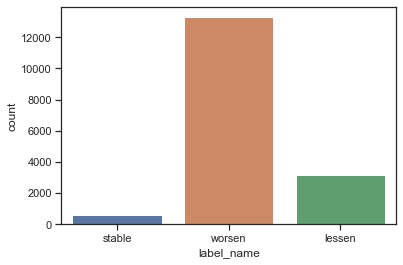

In [410]:
#visulize the data analytics:
#from the result ,we can say the database is imbalanced and mutliple classes tables
sns.set_theme(style="ticks", color_codes=True)

sns.barplot(x="label_name", y="count", data=merged_datasets_categories)


<b>above the labels are imbalanced and underfitting, we need to oversample the labels to the same number later on. </b>

#### from the result ,we can say the database is imbalanced and mutliple classes tables

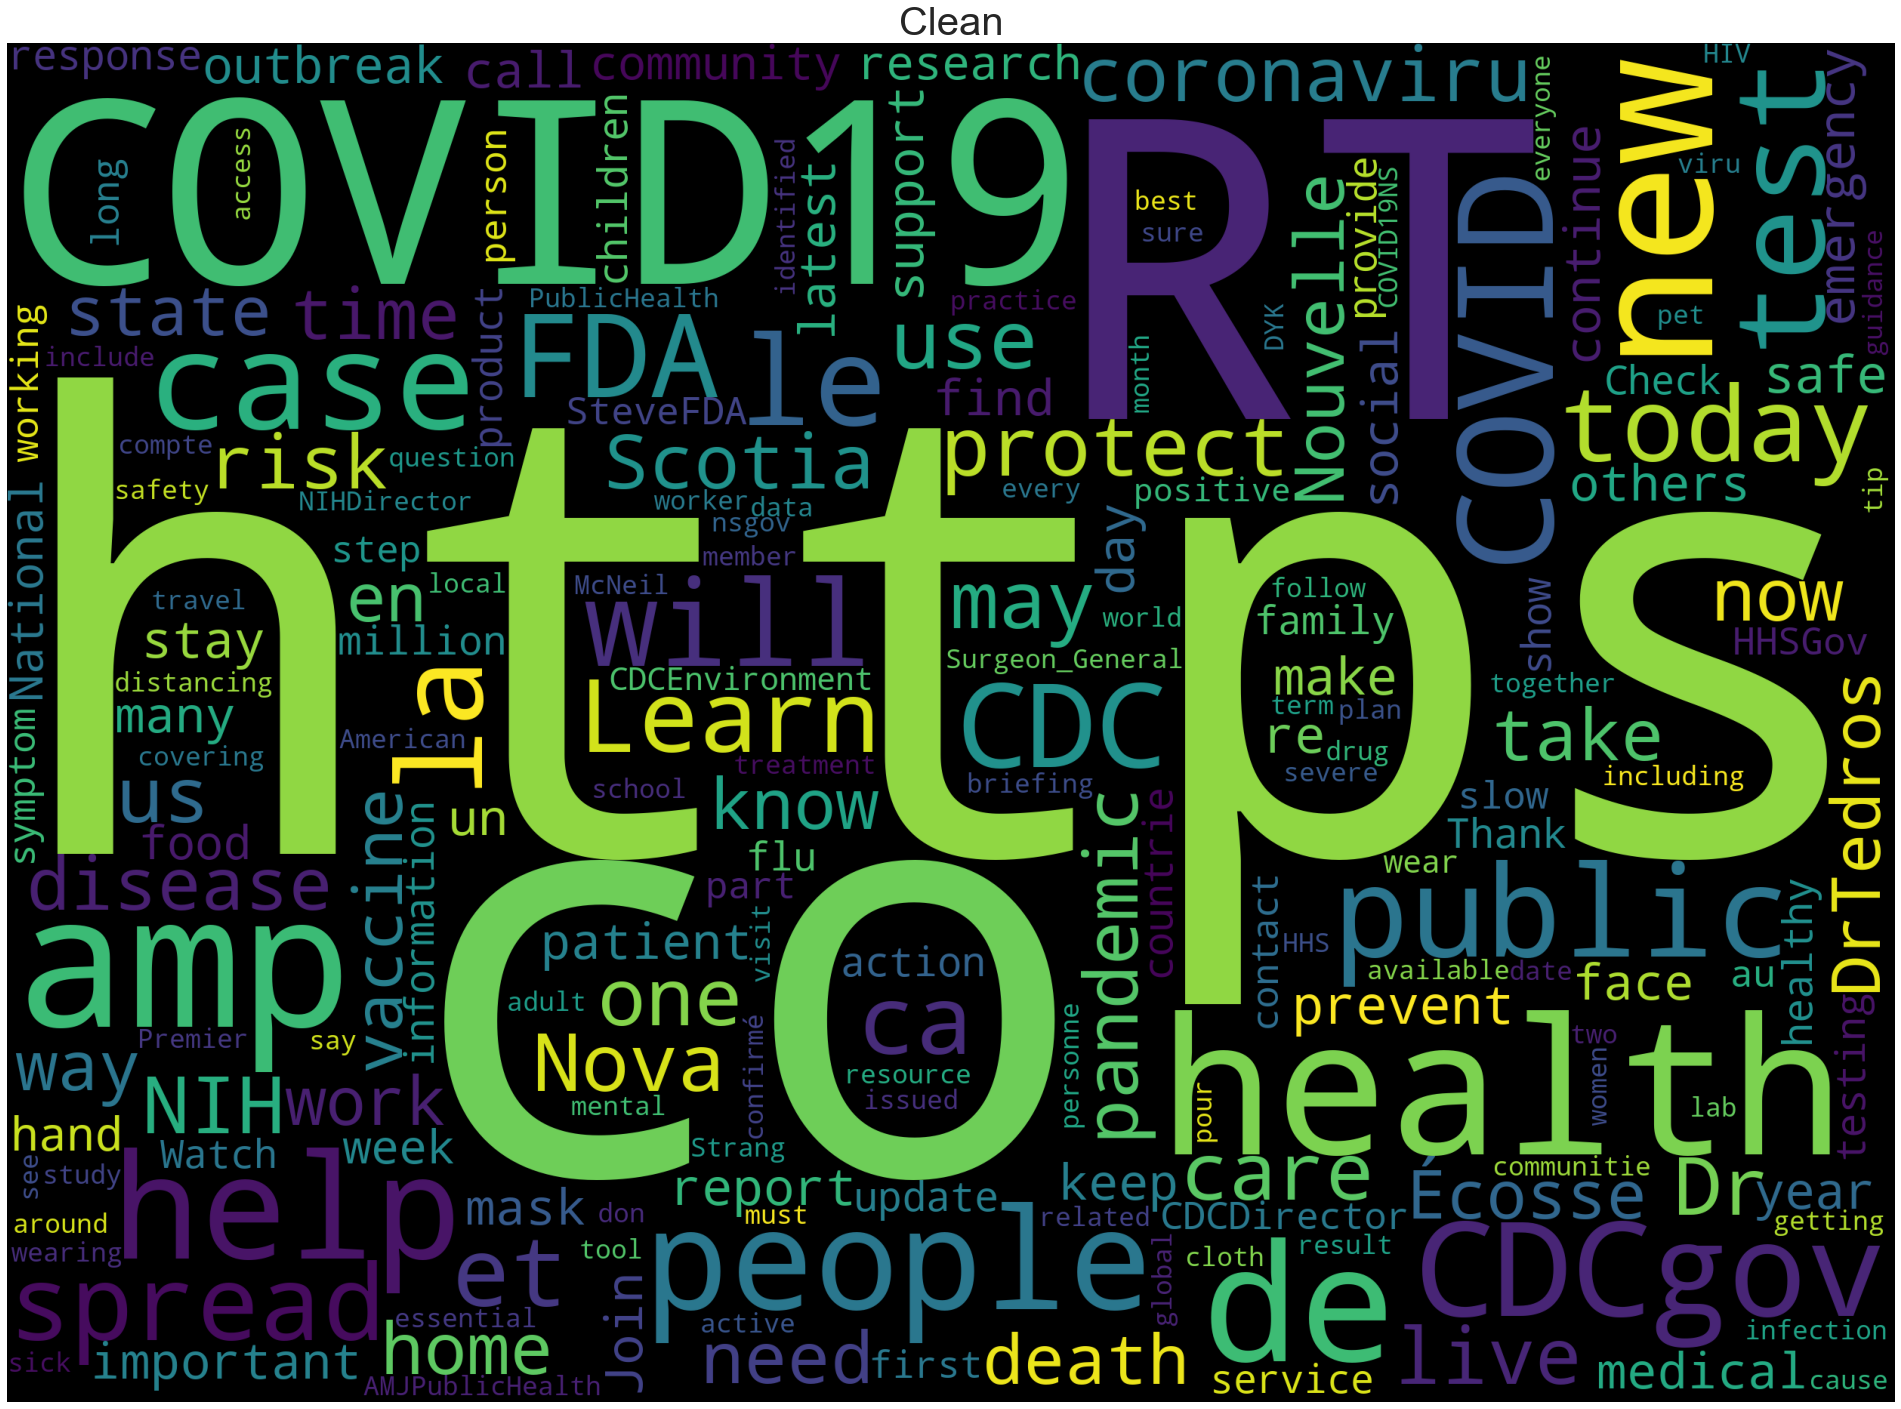

In [411]:
#WordCloud representation of most used words in each category of comments
#the purpose is to identify rare words and filter out to enhance model later on.
#!pip install wordcloud #install if we don't have it
def visualizeWordCloud(df):
    from wordcloud import WordCloud,STOPWORDS
    plt.figure(figsize=(40,25))
    text = df['text'].values
    cloud_toxic = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='black',
                              collocations=False,
                              width=2500,
                              height=1800
                             ).generate(" ".join(text))
    plt.axis('off')
    plt.title("Clean",fontsize=40)
    plt.imshow(cloud_toxic)
visualizeWordCloud(merged_datasets)

<h4>About we can see some high frequent words are only associated with twitter account name and technlogoy words like https. we need to add those words into stopwords to filter out</h4>

In [412]:
unrelated_stopwords = ['https','NIH', 'FDA', 'CDCgov', 'CDC', 'HHSGov', 'CDCMMWR'];

##### below we analyze the low frequent words and will add those in stop words in below function
##### apply for the stopwords tecnique to get rid of word "noise" which is not related to text topics.

In [413]:
#Eliminating features with extremely low frequency
#Keywords which occur in lesser frequency in the corpus usually does not play a role in text classification. 
#One can get rid of these low occurring features, resulting in better performance of the model.
#import necessary library if we didn't
import collections, itertools
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.tokenize import word_tokenize

In [434]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [107]:
#Write a function to prepare your text data by methods such as removing stop words. 
#You are allowed to use the NLTK library. You can find more information here: https://www.nltk.org/
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords 
import re
#from nltk.tokenize import word_tokenize

#note, this function is only for filtering stop word, later on, we will have to stem words, and group words
def filterStopWords(text_arr, lang):
    
    # by default it is english lang
    if lang is None:
        lang = 'english'
    new_text_arr = []
    extra_arr = []
    
#     for word in word_scores:
#         if word[1] < 1.05:
#             extra_arr.append(word[0])
            
    #update existing stop words
    stop_words = set(stopwords.words(lang)) 
    stop_words.update(unrelated_stopwords)
    stop_words.update(extra_arr)
    for one_text in text_arr:
        word_tokens = word_tokenize(one_text) 
        one_text_new = [w for w in word_tokens if not w in stop_words] 
        one_text_new = " ".join(one_text_new) 
        new_text_arr.append(one_text_new)
        
    return new_text_arr

In [100]:
#import library if we don't have
from nltk.stem.snowball import SnowballStemmer
#this function will apply stem/lemming to enhance the accuracy of ML model
def stemming(text):
    stemmer = SnowballStemmer("english")
    stemText = ""
    for word in text.split():
        stem = stemmer.stem(word)
        stemText += stem
        stemText += " "
    stemText = stemText.strip()
    return stemText
#usage
#newsitems_gloabl_df_new_new['text'] = newsitems_gloabl_df_new_new['text'].apply(stemming)

In [101]:
# remove puncturation
def filterPuncturation(text):
    import re
    one_text_new = re.sub(r'[?|!|\'|"|#]',r'',text)
    one_text_new = re.sub(r'[.|,|)|(|\|/]',r' ',one_text_new)
    return one_text_new

In [102]:
# filter special characts, including line changing character, redundant spaces and lower case all text
def filterSpecialCharsAndLowerCase(text):
    #nomalize text making them all lower case
    one_text = text.lower()
    #get rid of leading and tail spaces
    one_text_new = one_text.strip()
    #get rid of chaning line char
    one_text_new = one_text_new.replace("\n"," ")
    #clean up non-alpha character
    temp_new=''
    for word in one_text_new.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        temp_new += alpha_word
        temp_new += " "
    one_text_new = temp_new.strip()
    return one_text_new

In [103]:
# filter html tag
def filterHtmlTag(text):
    import re
    #clean up html tag:
    cleanr = re.compile('<.*?>')
    one_text_new = re.sub(cleanr, ' ', str(text))
    return one_text_new

In [104]:
# remove apostrophe because removing punctation and stopwords cant remove all apostrophe
def filterApostrophe(text):
    return np.char.replace(text,"'", "")

In [328]:
#single characters are not much useful in knowing of the document and few final fingle characters might be irrelevant symbols,
# so it is always good dbe remove the single characters
def filterSingleCharacter(text):
    new_text = ""
    for word in text.split():
        if len(word)>1:
            new_text = new_text + " " + word
    return new_text

In [159]:
# Here next function we will calculate the best scored words from raw text by utilizing ntlk library.
# Later on we will utilize TFIDF score to filter out low TFIDF words.
def handleLowFrequencyWords(df, label_names):
    word_fd = FreqDist()
    topic_word_fd = ConditionalFreqDist()

    for index, one_tuple in df.iterrows():
         for word in word_tokenize(one_tuple['text']):
            word_fd[word] += 1
            topic_word_fd[one_tuple['label_name']][word] += 1

    total_word_count = 0
    for one_topic in label_names:
        total_word_count += topic_word_fd[one_topic].N()

    word_scores = {}

    for word, freq in word_fd.items():
#         print(word, freq)
        word_score = 0
        for one_topic in label_names:
#             print(one_topic, topic_word_fd[one_topic][word], topic_word_fd[one_topic].N())
            one_topic_score = BigramAssocMeasures.chi_sq(topic_word_fd[one_topic][word],(freq, topic_word_fd[one_topic].N()), total_word_count)
            word_score += one_topic_score
        word_scores[word] = word_score


    lowest = sorted(word_scores.items(), key=lambda kv: kv[1], reverse=False)[:2000]
    print(lowest)
    #bestwords = set([w for w, s in best])

    #bestwords_dict = dict([(word, True) for word in words if word in bestwords])

    print('evaluating lowest words frequency')
    #evaluate_newsitems_classifier(best_word_feats)
    return lowest

In [160]:
#usage:
word_scores = handleLowFrequencyWords(new_df, label_names)

[('collect', 0.0028466694566289022), ('process', 0.03459485972928183), ('advis', 0.04402005649444094), ('chanc', 0.053019588951641716), ('nutrit', 0.056471092052159666), ('strong', 0.056471092052159666), ('decis', 0.06166183336780626), ('black', 0.06938121719810598), ('car', 0.07918029511842295), ('ahead', 0.07977045590137403), ('warn', 0.11153388503754441), ('anoth', 0.11928512930100538), ('messag', 0.1259366181060965), ('child', 0.13477573780107516), ('synthet', 0.13768094369954942), ('arthur', 0.13768094369954942), ('lactat', 0.13768094369954942), ('busph', 0.13768094369954942), ('kbdesalvo', 0.13768094369954942), ('asnkidney', 0.13768094369954942), ('memorandum', 0.13768094369954942), ('ez', 0.13768094369954942), ('tm', 0.13768094369954942), ('wage', 0.13768094369954942), ('aph', 0.13768094369954942), ('rich', 0.13768094369954942), ('bartlett', 0.13768094369954942), ('formal', 0.13768094369954942), ('hjt', 0.13768094369954942), ('dulcemariamph', 0.13768094369954942), ('fdaoncolog',

In [414]:
#this function will reuse the funcitons we defined above to generate new df
#input parameter: the old dataframe extracted by the first function from xml files
def normalizeMultiLabelsDf(df):
    new_df = df
    #filter html tag
    new_df['text'] = new_df['text'].apply(filterHtmlTag)
    #filter puncturation
    new_df['text'] = new_df['text'].apply(filterPuncturation)
    #filter apostroph
    new_df['text'] = new_df['text'].apply(filterApostrophe)
    #filter special characters
    new_df['text'] = new_df['text'].apply(filterSpecialCharsAndLowerCase)
#     filter single chachacter
    new_df['text'] = new_df['text'].apply(filterSingleCharacter)
    new_df['text'] = filterStopWords(new_df['text'], 'english')
    #stem words
    new_df['text'] = new_df['text'].apply(stemming)
    new_df.to_csv('newsitems_gloabl_df_normalized.csv', index = False, header = True)
    #new_df = normailizeTopics(new_df)
    return new_df;

In [415]:
#usage
new_df = normalizeMultiLabelsDf(merged_datasets)
print(new_df)

                                                    text        date  \
0      drink better crash friend couch crash highway ...  2020-01-01   
1      cheer hope happiest healthiest year decad yet ...  2020-01-01   
2      fit physic activ day doesnt hard break exercis...  2020-01-01   
3      cdc wish famili healthi happynewyear co awgr yipi  2020-01-01   
4      year apha resolv champion health peopl amp com...  2020-01-01   
...                                                  ...         ...   
17065  visit mobil clinic conduct medicosdelmundo amp...  2020-09-27   
17066  rt cdctravel look covid risk certain destin ch...  2020-09-27   
17067  rt samhsagov talk someon thought feel save lif...  2020-09-27   
17068  rt drtedro weve learn much covid pandem couldn...  2020-09-27   
17069  live work play impact health nih nimhd host vi...  2020-09-27   

       new_confirmed  new_recovered  spread label_name expected_date  \
0                0.0            0.0       2     lessen    2020-

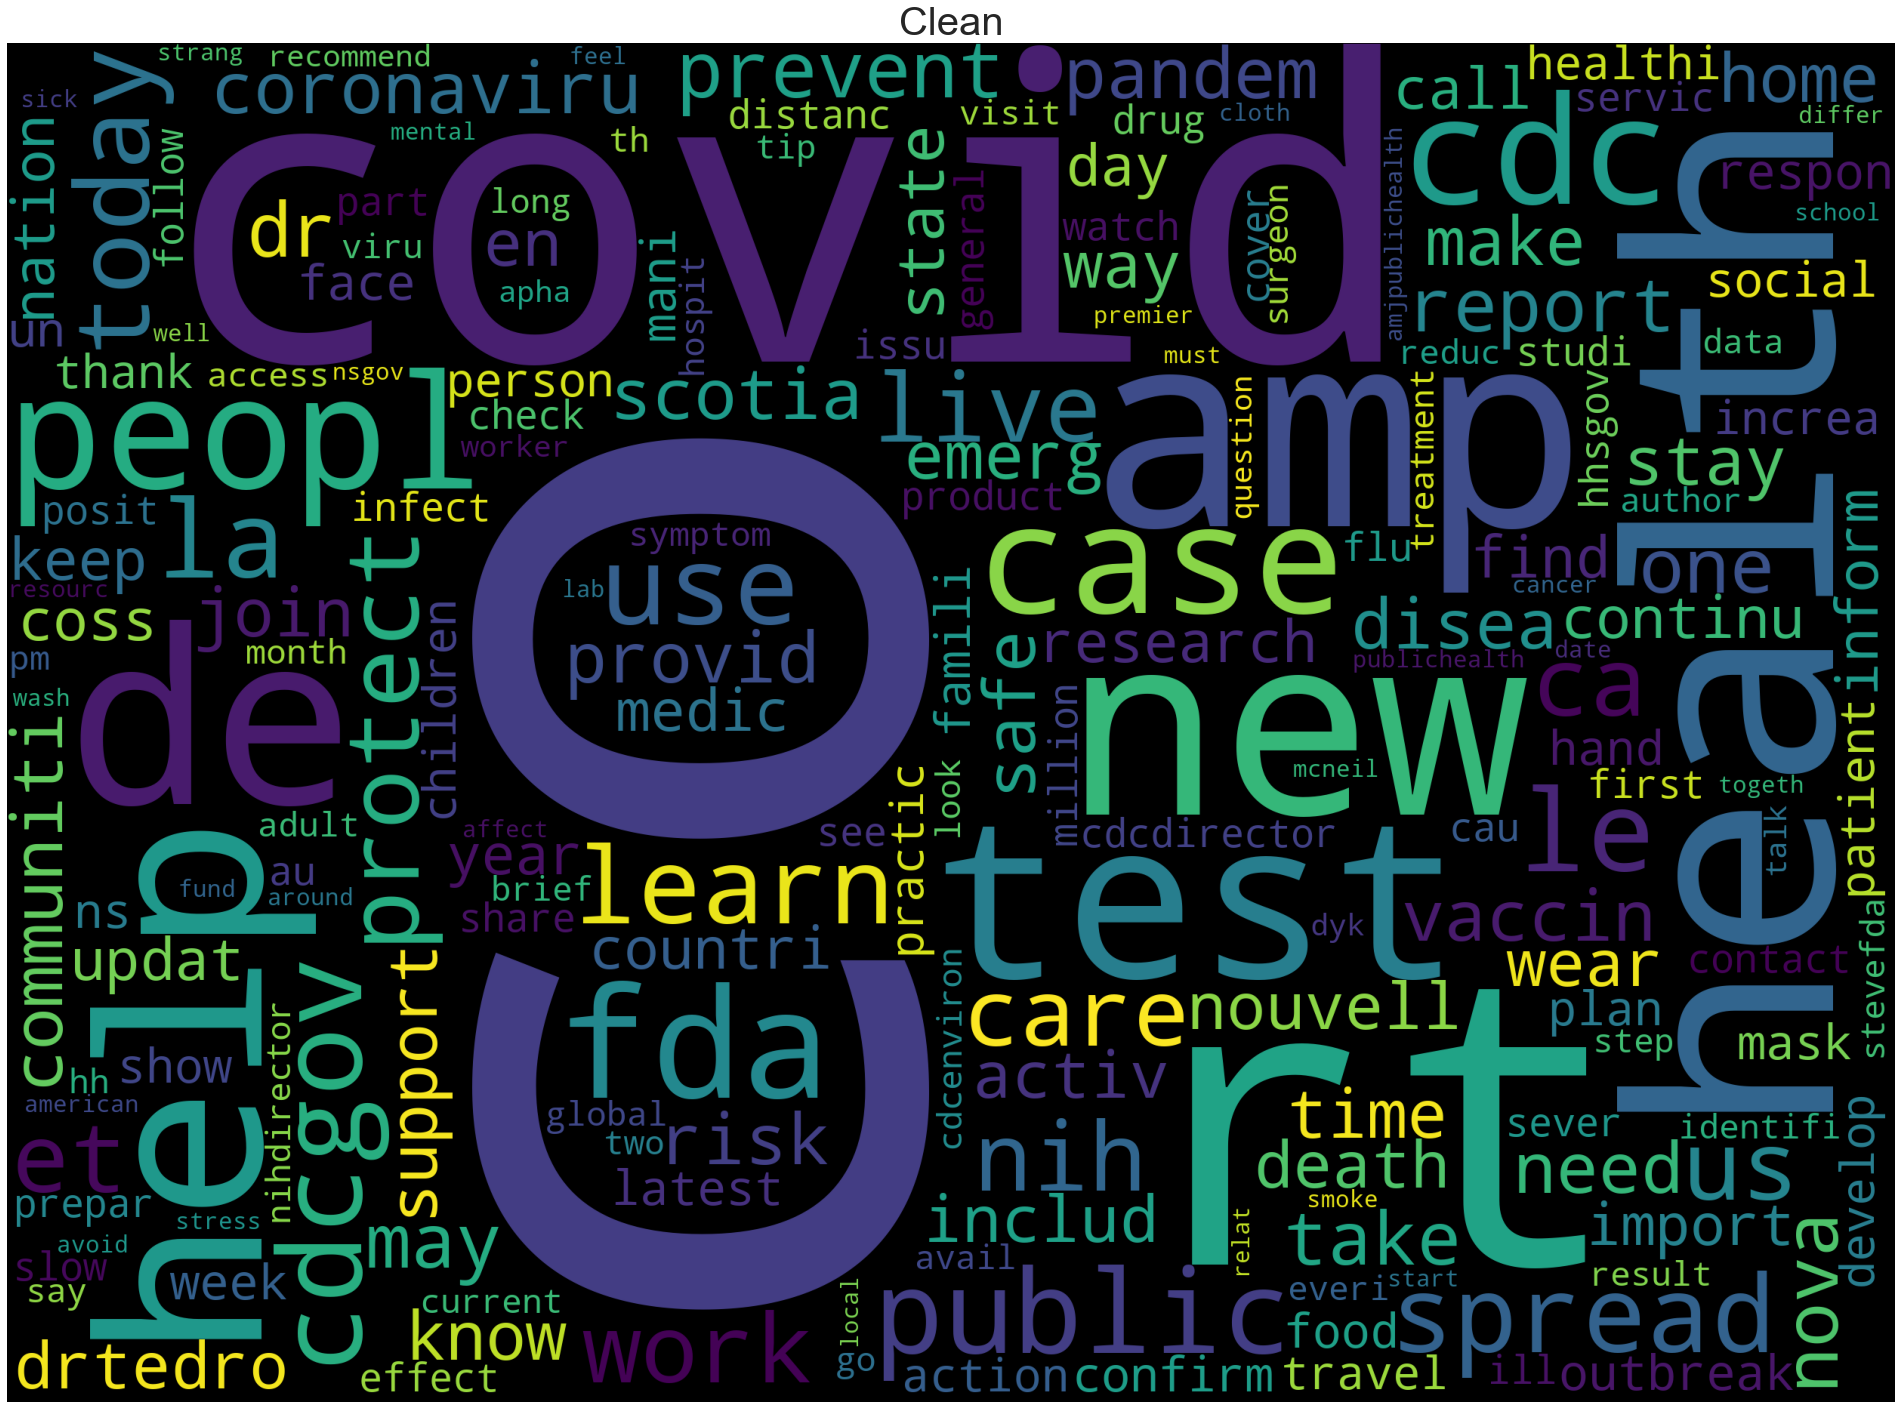

In [416]:
visualizeWordCloud(new_df)

<h3>Generate Train, Validate and test Datasets</h3>

In [417]:
new_df.head(5)


,text,date,new_confirmed,new_recovered,spread,label_name,expected_date,expected_new_confirmed,expected_new_recovered,expected_spread,expected_label_name
0,drink better crash friend couch crash highway ...,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
1,cheer hope happiest healthiest year decad yet ...,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
2,fit physic activ day doesnt hard break exercis...,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
3,cdc wish famili healthi happynewyear co awgr yipi,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen
4,year apha resolv champion health peopl amp com...,2020-01-01,0.0,0.0,2,lessen,2020-01-15,0.0,0.0,2,lessen


In [418]:
print(new_df.shape)

(17070, 11)


In [419]:
#Build your model based on the data from November 1, 2019, to April 1,
# 2020. Apply the data from April 1, 2020, to September 1, 2020, as your model's
# development dataset. Then use the data from September 1, 2020, to October
# 1, 2020, to validate(test) your mode
merged_datasets_train_df = new_df.loc[(new_df['date']>='2019-11-01') & (new_df['date']<'2020-04-01')]
merged_datasets_validate_df = new_df.loc[(new_df['date']>='2020-04-01') & (new_df['date']<'2020-09-01')]
merged_datasets_test_df = new_df.loc[(new_df['date']>='2020-09-01') & (new_df['date']<'2020-10-01')]
print(merged_datasets_train_df.shape)
print(merged_datasets_validate_df.shape)
print(merged_datasets_test_df.shape)

(4223, 11)
(10756, 11)
(2091, 11)


<h3>Utilize NLTK native model</h3>

In [248]:
def tokenizeText(text_arr):
    new_text_arr =[]
    for one_text in text_arr:
        word_tokens = word_tokenize(one_text) 
        new_text_arr.append(word_tokens)
        
    return new_text_arr

In [250]:
tokenized_df_train = merged_datasets_train_df.copy()
tokenized_df_train['text'] = tokenizeText(tokenized_df_train['text'])

In [251]:
def normalizeNltkDatasets(df):
    from nltk.tokenize import word_tokenize
    
    data=([(row['text'], row['label_name']) for index, row in df.iterrows()])
    tokens=set(word.lower() for words in data for word in words[0])
    new_df = [({word: (word in x[0]) for word in tokens}, x[1]) for x in data] 
    return new_df

In [252]:
tokenized_df_train = normalizeNltkDatasets(tokenized_df_train)

In [253]:
tokenized_df_validate = merged_datasets_validate_df.copy()
tokenized_df_validate['text'] = tokenizeText(tokenized_df_validate['text'])

In [254]:
tokenized_df_validate = normalizeNltkDatasets(tokenized_df_validate)

In [255]:
tokenized_df_test = merged_datasets_test_df.copy()
tokenized_df_test['text'] = tokenizeText(tokenized_df_test['text'])

In [256]:
tokenized_df_test = normalizeNltkDatasets(tokenized_df_test)

In [257]:
# ConditionalExponentialClassifier
# DecisionTreeClassifier
# MaxentClassifier
# NaiveBayesClassifier
# WekaClassifier
NaiveBayesClassifier = nltk.NaiveBayesClassifier.train(tokenized_df_train)

In [258]:
NaiveBayesClassifier.show_most_informative_features()

Most Informative Features
                  exempt = True           stable : worsen =     83.0 : 1.0
                    ncov = True           lessen : worsen =     38.5 : 1.0
                   dautr = True           stable : worsen =     35.6 : 1.0
                 pouvoir = True           stable : worsen =     35.6 : 1.0
                 profess = True           stable : worsen =     35.6 : 1.0
              loignement = True           stable : lessen =     33.0 : 1.0
                     dog = True           lessen : worsen =     28.2 : 1.0
                februari = True           lessen : worsen =     28.2 : 1.0
                 capacit = True           stable : worsen =     27.7 : 1.0
                 cessair = True           stable : worsen =     27.7 : 1.0


<b>apply model on 2020-04-01 to 2020-09-01</b>

In [259]:
acc=nltk.classify.accuracy(NaiveBayesClassifier, tokenized_df_validate)

In [260]:
print("Accuracy:", acc)

Accuracy: 0.6754070265638389


<h3>Utilize TFID Vectorizer with SKlearn Models</h3>

In [318]:
#TfidfVectorizer willl convert a collection of raw documents to a matrix of TF-IDF features. It enables n-gram model
#An n-gram model is a type of probabilistic language model for predicting the next item in such a sequence in the form of a (n − 1)–order Markov model
#Two benefits of n-gram models (and algorithms that use them) are simplicity and scalability – with larger n, a model can store more context with a well-understood space–time tradeoff, enabling small experiments to scale up efficiently.
#here we set n-gram range from 1 - 3

def TfidfVectorizerText(df):
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer

    new_df = df.copy()
    text = df['text']
    y = df['expected_spread']
    y_name = df['expected_label_name']

    count_vect = CountVectorizer()
    X_counts = count_vect.fit_transform(text)

    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_counts)
    
    return X_tfidf, y, y_name

In [420]:
#usage
X_tfidf, y, y_name = TfidfVectorizerText(new_df)
print(X_tfidf, y, y_name)
print(X_tfidf.shape)
print(y.shape)
print(y_name.shape)

  (0, 18741)	0.07105419770473499
  (0, 18165)	0.21447940040268268
  (0, 8850)	0.3142054607787016
  (0, 7904)	0.3374765693661461
  (0, 7217)	0.20144553564379314
  (0, 5240)	0.3374765693661461
  (0, 5077)	0.2329461682026095
  (0, 3810)	0.6134276742504574
  (0, 3685)	0.32386384349228103
  (0, 3300)	0.04623669522574823
  (0, 1648)	0.21042954334310973
  (1, 24922)	0.30115235362649684
  (1, 24898)	0.19925569999097842
  (1, 24784)	0.4103070788438104
  (1, 15317)	0.17647934297852122
  (1, 12441)	0.23093227480567574
  (1, 9066)	0.28413537567251
  (1, 8601)	0.34072182612686436
  (1, 8438)	0.4103070788438104
  (1, 4295)	0.3056097044588524
  (1, 3300)	0.0562149940930726
  (1, 2936)	0.39375660306145394
  (2, 16250)	0.24174632035302668
  (2, 13382)	0.29424109901719997
  (2, 10249)	0.42763109844198355
  :	:
  (17068, 13835)	0.431109598830165
  (17068, 13775)	0.2703009107903601
  (17068, 11979)	0.17030445043568138
  (17068, 5130)	0.20017943599547883
  (17068, 5106)	0.3149667726946526
  (17068, 5037)	0

In [419]:
#Build your model based on the data from November 1, 2019, to April 1,
# 2020. Apply the data from April 1, 2020, to September 1, 2020, as your model's
# development dataset. Then use the data from September 1, 2020, to October
# 1, 2020, to validate(test) your mode
merged_datasets_train_df = new_df.loc[(new_df['date']>='2019-11-01') & (new_df['date']<'2020-04-01')]
merged_datasets_validate_df = new_df.loc[(new_df['date']>='2020-04-01') & (new_df['date']<'2020-09-01')]
merged_datasets_test_df = new_df.loc[(new_df['date']>='2020-09-01') & (new_df['date']<'2020-10-01')]
print(merged_datasets_train_df.shape)
print(merged_datasets_validate_df.shape)
print(merged_datasets_test_df.shape)

(4223, 11)
(10756, 11)
(2091, 11)


In [431]:
#usage
(4223, 11)
(10756, 11)
(2091, 11)
X_tfidf_train, y_train, y_name_train = X_tfidf[0:4223], y[0:4223], y_name[0:4223]
X_tfidf_validate, y_validate, y_name_validate = X_tfidf[4223:(4223+10756)], y[4223:(4223+10756)], y_name[4223:(4223+10756)]
X_tfidf_test, y_test, y_name_test = X_tfidf[(4223+10756):(4223+10756+2091)], y[(4223+10756):(4223+10756+2091)], y_name[(4223+10756):(4223+10756+2091)]

<h4>Training Data oversampling</h4>

In [338]:
from imblearn.over_sampling import SMOTE
strategy = {0:5000, 1:5000, 2:5000}
oversample = SMOTE(sampling_strategy=strategy)
X_tfidf_train, y_train = oversample.fit_resample(X_tfidf_train, y_train)

In [126]:
merged_datasets_categories_resampling = pd.DataFrame(columns=['spread', 'count'])
merged_datasets_categories_resampling['spread'] = np.unique(y_train,return_counts=1)[0]
merged_datasets_categories_resampling['count'] = np.unique(y_train,return_counts=1)[1]          

In [400]:
merged_datasets_categories_resampling.head(3)

,spread,count
0,0.0,50000
1,1.0,50000
2,2.0,50000


In [402]:
#add a column of spread label names
label_names = ['lessen', 'worsen', 'stable']
merged_datasets_categories_resampling['label_name'] = label_names

In [403]:
merged_datasets_categories_resampling

,spread,count,label_name
0,0.0,50000,lessen
1,1.0,50000,worsen
2,2.0,50000,stable


<AxesSubplot:xlabel='label_name', ylabel='count'>

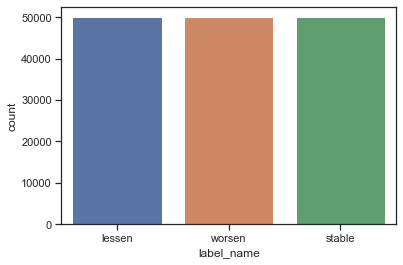

In [404]:
#visulize the data analytics:
#from the result ,we can say the database is imbalanced and mutliple classes tables
sns.set_theme(style="ticks", color_codes=True)

sns.barplot(x="label_name", y="count", data=merged_datasets_categories_resampling)


<h4>Evaluation Reusable Functions</h4>

In [432]:
# This function is for reporting evaulation

def print_all_score(y_true, y_pred, model):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    modelName = model.__class__.__name__
    print("ML model: ", modelName)
    print("---")   
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: {}", accuracy)
    print("---")
    return accuracy

<h4>Model Training and Evaluation Reusable Functions</h4>

In [436]:
def randomForest(x_train, x_validate, y_train, y_validate):
    from sklearn.ensemble import RandomForestClassifier
    rc = RandomForestClassifier(n_jobs=-1)
    rc.fit(x_train, y_train)
    y_pred = rc.predict(x_validate)
    accuracy = print_all_score(y_validate, y_pred, rc)
    return rc, accuracy

In [437]:
def NeuralNetwork(x_train, x_validate, y_train, y_validate):
    #we choose MLPClassifier because target is binary instead of regression
    from sklearn.neural_network import MLPClassifier
    mlp = MLPClassifier(max_iter=20)
    mlp.fit(x_train, y_train)
    y_pred = mlp.predict(x_validate)
    accuracy = print_all_score(y_validate, y_pred, mlp)
    return mlp, accuracy

In [438]:
def SVM(x_train, x_validate, y_train, y_validate):
    #we choose SVC because target is binary instead of regression
    from sklearn.svm import SVC
    svc = SVC()
    svc.fit(x_train, y_train)
    y_pred = svc.predict(x_validate)
    accuracy = print_all_score(y_validate, y_pred, svc)
    return svc, accuracy

<b>Build model on 2019-12-01-2020-04-01, and apply on 2020-04-01-2020-09-01</b>

In [439]:
rc, accuracy = randomForest(X_tfidf_train, X_tfidf_validate, y_train, y_validate)

ML model:  RandomForestClassifier
---
Accuracy: {} 0.8472480476013388
---


In [440]:
nn, accuracy = NeuralNetwork(X_tfidf_train, X_tfidf_validate, y_train, y_validate)

ML model:  MLPClassifier
---
Accuracy: {} 0.7833767199702492
---


In [441]:
svm, accuracy = SVM(X_tfidf_train, X_tfidf_validate, y_train, y_validate)

ML model:  SVC
---
Accuracy: {} 0.8409259947936035
---


<b>Above it looks like Super Vector Machine and Random Forest Tree Basedline model are better than Neurtal Network baseline model</b>

<h3>Test the model on the data on 2020-09-01 to 2020-10-01</h3>
<b>Note: we already generate X_tfidf_test for features and y_test for labels "lessen"(2), "worsen"(1) and "stable"(0). <br>
    And we already shifted the X_tfidf_test date to the date after 14 days (for example: the features predicted the labels which happen after 14 days.<br></b>
Refer to preivous section #Shifting 14 Days

<b>Model A - TFID Vectorizer + Random Forest</b>

In [442]:
#choose the best model neural network 
y_pred_on_09_to_10 = rc.predict(X_tfidf_test)
from sklearn.metrics import accuracy_score
print("---") 
print("ML model: ", rc.__class__.__name__)
print("---")   
accuracy = accuracy_score(y_test, y_pred_on_09_to_10)
print("Accuracy: {}", accuracy)
print("---") 

---
ML model:  RandomForestClassifier
---
Accuracy: {} 0.7336202773792444
---


In [443]:
#the combined result "predicted_spread" shown here:
merged_datasets_test_df['predicted_spread'] = y_pred_on_09_to_10
merged_datasets_test_df

,text,date,new_confirmed,new_recovered,spread,label_name,expected_date,expected_new_confirmed,expected_new_recovered,expected_spread,expected_label_name,predicted_spread
14979,project train staff volunt athen greec distrib...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14980,athen greec one citi partnership healthi citi ...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,2
14981,rt cdcglobal cdc work dilig fight respiratori ...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14982,septemb nationalfoodsafetyandeducationmonth mo...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,2
14983,rt drtedro commit ensur promot gender equal pa...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17065,visit mobil clinic conduct medicosdelmundo amp...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17066,rt cdctravel look covid risk certain destin ch...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17067,rt samhsagov talk someon thought feel save lif...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17068,rt drtedro weve learn much covid pandem couldn...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1


<b>Model B - TFID Vectorizer + Neural Network</b>

In [450]:
#choose the best model neural network 
y_pred_on_09_to_10 = nn.predict(X_tfidf_test)
from sklearn.metrics import accuracy_score
print("---") 
print("ML model: ", nn.__class__.__name__)
print("---")   
accuracy = accuracy_score(y_test, y_pred_on_09_to_10)
print("Accuracy: {}", accuracy)
print("---") 

---
ML model:  MLPClassifier
---
Accuracy: {} 0.6346245815399331
---


In [446]:
#the combined result "predicted_spread" shown here:
merged_datasets_test_df['predicted_spread'] = y_pred_on_09_to_10
merged_datasets_test_df

,text,date,new_confirmed,new_recovered,spread,label_name,expected_date,expected_new_confirmed,expected_new_recovered,expected_spread,expected_label_name,predicted_spread
14979,project train staff volunt athen greec distrib...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14980,athen greec one citi partnership healthi citi ...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14981,rt cdcglobal cdc work dilig fight respiratori ...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14982,septemb nationalfoodsafetyandeducationmonth mo...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,2
14983,rt drtedro commit ensur promot gender equal pa...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,2
...,...,...,...,...,...,...,...,...,...,...,...,...
17065,visit mobil clinic conduct medicosdelmundo amp...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17066,rt cdctravel look covid risk certain destin ch...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,2
17067,rt samhsagov talk someon thought feel save lif...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17068,rt drtedro weve learn much covid pandem couldn...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1


<b>Model C - TFID Vectorizer + SVM</b>

In [449]:
#choose the best model neural network 
y_pred_on_09_to_10 = svm.predict(X_tfidf_test)
from sklearn.metrics import accuracy_score
print("---") 
print("ML model: ", svm.__class__.__name__)
print("---")   
accuracy = accuracy_score(y_test, y_pred_on_09_to_10)
print("Accuracy: {}", accuracy)
print("---") 

---
ML model:  SVC
---
Accuracy: {} 0.7068388330942132
---


In [448]:
#the combined result "predicted_spread" shown here:
merged_datasets_test_df['predicted_spread'] = y_pred_on_09_to_10
merged_datasets_test_df

,text,date,new_confirmed,new_recovered,spread,label_name,expected_date,expected_new_confirmed,expected_new_recovered,expected_spread,expected_label_name,predicted_spread
14979,project train staff volunt athen greec distrib...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14980,athen greec one citi partnership healthi citi ...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14981,rt cdcglobal cdc work dilig fight respiratori ...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
14982,septemb nationalfoodsafetyandeducationmonth mo...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,2
14983,rt drtedro commit ensur promot gender equal pa...,2020-09-01,114698.0,17873.0,1,worsen,2020-09-15,112158.0,17208.0,1,worsen,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17065,visit mobil clinic conduct medicosdelmundo amp...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17066,rt cdctravel look covid risk certain destin ch...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17067,rt samhsagov talk someon thought feel save lif...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1
17068,rt drtedro weve learn much covid pandem couldn...,2020-09-27,122953.0,15853.0,1,worsen,2020-10-11,0.0,0.0,2,lessen,1


<b>Concludsion: based on tested performance on 9-1 to 10-1 of A, B and C three different model, we can see Random Forest is the best 0.73 accuracy</b>